In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/캡스톤

/content/drive/MyDrive/캡스톤


In [3]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!sudo apt-get install g++ openjdk-8-jdk python3-dev python3-pip curl
!pip install konlpy
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
!pip install mecab-python3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:9.3.0-1ubuntu2).
python3-dev is already the newest version (3.8.2-0ubuntu2).
curl is already the newest version (7.68.0-1ubuntu2.18).
openjdk-8-jdk is already the newest version (8u362-ga-0ubuntu1~20.04.1).
python3-pip is already the newest version (20.0.2-5ubuntu1.8).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.68.0-1ubuntu2.18).
git is already the newest version (1:2.25.1-1ubuntu3.11).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.
Looking in indexes: https://pypi.org/simple, https://us

<h1> 1. 필요한 라이브러리 임포트 </h1>

In [5]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt, Mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<h1> 2. Mecab으로 정제된 데이터 불러오기 </h1>
<li> review data -> 네이버 영화 리뷰 데이터 ---- 이미 preprocessing까지 완료된 상태에서 불러와서 hangul_only와 mecab_preprocessing 과정 생략</li>
<li> shopping data -> 네이버 쇼핑 리뷰 데이터  ---- 이미 preprocessing까지 완료된 상태에서 불러와서 hangul_only와 mecab_preprocessing 과정 생략 </li>
<li> steam data -> 게임 리뷰 데이터 </li>
<li> AI Hub data -> AI Hub 대화 관련 데이터 </li>

In [6]:
# 한글만 추출하기
def hangul_only(df : pd.DataFrame, convert_column : str) -> pd.DataFrame:
    df['sentence'] = df[convert_column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")
    df['sentence'] = df['sentence'].replace('^ +', '')
    df['sentence'].replace('', np.nan, inplace = True)
    df = df.dropna(how = 'any')
    return df

# 형태소 분석 -> mecab 이용해서 명사, 형용사, 동사만 추출
def mecab_preprocessing(df : pd.DataFrame, convert_column : str) -> pd.DataFrame:
    tags = ['JK', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'EP', 'EF', 'EC', 'ETN', 'ETM']

    from konlpy.tag import Mecab

    mecab = Mecab()

    for idx, row in tqdm(df.iterrows(), desc = 'removing josa', total = len(df)):
        josa_removed = [x[0] for x in mecab.pos(row['sentence']) if x[1] not in tags]
        df.loc[idx, 'preprocessed_sentence'] = ' '.join(josa_removed)
    
    return df

# 데이터 간소화 하기 (필요한 것만 불러오기)
def get_data_only_review(df : pd.DataFrame) -> pd.DataFrame:
    return df[['sentence', 'preprocessed_sentence', 'label']]

# 각 데이터 합치
def concat_individual_data(data_list : list) -> pd.DataFrame:
    df = data_list[0].copy()
    for i in range(1, len(data_list)):
        df = pd.concat([df, data_list[i]], axis = 0).reset_index(drop = True)
    return df.reset_index(drop = True)

In [7]:
review_df = pd.read_csv('mecab_data.csv').drop(['index', 'id'], axis = 1)
review_df.head()

,document,label,sentence,preprocessed_sentence
0,아 더빙.. 진짜 짜증나네요 목소리,0,아 더빙 진짜 짜증나네요 목소리,아 더 빙 진짜 짜증 나 네요 목소리
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,흠 포스터 초딩 영화 줄 오버 연기 가볍 않
2,너무재밓었다그래서보는것을추천한다,0,너무재밓었다그래서보는것을추천한다,너무 재 밓었다그래서보는것을추천한다
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,교도소 이야기구먼 솔직히 재미는 없다평점 조정,교도소 이야기 구먼 솔직히 재미 없 평점 조정
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,사이몬페그 익살 스런 연기 돋보였 영화 스파이더맨 늙 보이 했 커스틴 던스트 너무나...


In [8]:
shopping_df = pd.read_csv('shopping_review.csv')
shopping_df.head()

,ratings,reviews,sentence,preprocessed_sentence
0,5,배공빠르고 굿,배공빠르고 굿,배공 빠르 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,택배 엉망 이 네 용 저희 집 밑 층 말 없이 놔두 가
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다 바느질이 조금 엉...,아주 좋 바지 정말 좋 2 개 더 구매 했 이 가격 대박 입니다 바느질 조금 엉성 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다 전화...,선물 용 빨리 받 전달 했어야 하 상품 이 머그 컵 와서 당황 했 전화 했 바로 주...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,민트색상 예뻐요 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,민트 색상 예뻐요 옆 손잡이 거 용도 사용 되 ㅎㅎ


In [9]:
shopping_df['label'] = shopping_df['ratings'].apply(lambda x : 1 if x >= 4 else 0)
shopping_df['label'].value_counts()

0    99955
1    99953
Name: label, dtype: int64

In [10]:
shopping_df.head()

,ratings,reviews,sentence,preprocessed_sentence,label
0,5,배공빠르고 굿,배공빠르고 굿,배공 빠르 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,택배 엉망 이 네 용 저희 집 밑 층 말 없이 놔두 가,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다 바느질이 조금 엉...,아주 좋 바지 정말 좋 2 개 더 구매 했 이 가격 대박 입니다 바느질 조금 엉성 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다 전화...,선물 용 빨리 받 전달 했어야 하 상품 이 머그 컵 와서 당황 했 전화 했 바로 주...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,민트색상 예뻐요 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,민트 색상 예뻐요 옆 손잡이 거 용도 사용 되 ㅎㅎ,1


In [11]:
steam_df = pd.read_csv('steam.csv')
steam_df.head()

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [12]:
steam_df = hangul_only(steam_df, 'reviews')
steam_df = mecab_preprocessing(steam_df, 'sentence')
print('결측치 제거 및 중복 제거 후의 데이터 개수 : ', len(steam_df))
steam_df.head()

<ipython-input-6-23b44c06866a>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sentence'] = df[convert_column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")
removing josa: 100%|██████████| 100000/100000 [00:26<00:00, 3766.44it/s]

결측치 제거 및 중복 제거 후의 데이터 개수 :  100000


,label,reviews,sentence,preprocessed_sentence
0,0,노래가 너무 적음,노래가 너무 적음,노래 너무 적
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다.",돌겠네 진짜 황숙아 어크 공장 그만 돌려라 죽는다,돌 진짜 황숙 아 어 크 공장 그만 돌려라 죽
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지,막노동 체험 판 막노동 하 사람 인데 장비 내 사 돼 뭐 지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??,차악차악차악 정말 이래서 왕국을 되찾을 수 있는거야,차악 차악 차악 정말 이래서 왕국 되찾 수 있 거 야
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요,시간 때우기에 좋음 도전과제는 50시간이면 다 깰 수 있어요,시간 때우 좋 전 과제 50 시간 이 다 깰 수 있


<h3> ai hub 데이터 따로 나누기 </h3>

In [41]:
aihub_df = pd.read_excel('감성분석 데이터.xlsx')
aihub_df.fillna('', inplace = True)
aihub_df['reviews'] = aihub_df['사람문장1'] + ' ' + aihub_df['시스템문장1'] + ' ' + aihub_df['사람문장2'] + ' ' + aihub_df['시스템문장2'] + ' ' + aihub_df['사람문장3'] + ' ' + aihub_df['시스템문장3']
#aihub_df['sentence'] = aihub_df['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")
#aihub_df['sentence'] = aihub_df['sentence'].str.replace('^ +', "")
#aihub_df['sentence'].replace('', np.nan, inplace = True)
aihub_df = hangul_only(aihub_df, 'reviews')
aihub_df = aihub_df.dropna(how = 'any').reset_index(drop = True)
print('제거된 ai hub 데이터 {}'.format(len(aihub_df)))

<ipython-input-27-18df0c5db902>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sentence'] = df[convert_column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]","")


제거된 ai hub 데이터 51630


In [43]:
aihub_df = mecab_preprocessing(aihub_df, 'sentence')
aihub_df.head(3)

removing josa: 100%|██████████| 15286/15286 [00:09<00:00, 1677.35it/s]


,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3,reviews,sentence,length,label,preprocessed_sentence
0,1,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,혼자 해결하기로 했군요. 혼자서 해결하기 힘들면 주위에 의논할 사람을 찾아보세요.,,,일은 왜 해도 해도 끝이 없을까? 화가 난다. 많이 힘드시겠어요. 주위에 의논할 상...,일은 왜 해도 해도 끝이 없을까 화가 난다 많이 힘드시겠어요 주위에 의논할 상대가 ...,130,0,일 왜 해도 해도 끝 없 화 난 다 많이 힘드 주위 의논 할 상대 있 그냥 내 해결...
1,2,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,월급이 줄어든 만큼 소비를 줄일 계획이군요.,,,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....,이번 달에 또 급여가 깎였어 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나 급...,156,0,이번 달 또 급여 깎였 물가 오르 월급 자꾸 깎이 너무 화가 급여 줄 속상하 월급 ...
2,3,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,스트레스받지 않기 위해선 인간관계에 있어 약간의 거리를 두는 게 좋겠군요.,,,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사에 신입이 들어왔는데 말투가 거슬려 그런 애를 매일 봐야 한다고 생각하니까 스트...,213,0,회사 신입 들어왔 말투 거슬려 그런 애 매일 봐야 한다고 생각 하 스트레스 받 회사...


In [42]:
aihub_df['length'] = aihub_df['sentence'].apply(lambda x : len(x))
aihub_df['length'].describe()

aihub_df = aihub_df[(aihub_df['감정_대분류'] == '기쁨') | (aihub_df['감정_대분류'] == '분노')].reset_index(drop = True)
aihub_df['label'] = aihub_df['감정_대분류'].apply(lambda x : 1 if x == '기쁨' else 0)
aihub_df.head(3)

,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3,reviews,sentence,length,label
0,1,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,혼자 해결하기로 했군요. 혼자서 해결하기 힘들면 주위에 의논할 사람을 찾아보세요.,,,일은 왜 해도 해도 끝이 없을까? 화가 난다. 많이 힘드시겠어요. 주위에 의논할 상...,일은 왜 해도 해도 끝이 없을까 화가 난다 많이 힘드시겠어요 주위에 의논할 상대가 ...,130,0
1,2,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,월급이 줄어든 만큼 소비를 줄일 계획이군요.,,,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....,이번 달에 또 급여가 깎였어 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나 급...,156,0
2,3,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,스트레스받지 않기 위해선 인간관계에 있어 약간의 거리를 두는 게 좋겠군요.,,,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사에 신입이 들어왔는데 말투가 거슬려 그런 애를 매일 봐야 한다고 생각하니까 스트...,213,0


<h1> 3. 데이터 전처리 및 EDA</h1>

In [33]:
review_data = get_data_only_review(review_df)
shopping_data = get_data_only_review(shopping_df)
steam_data = get_data_only_review(steam_df)
#aihub_data = get_data_only_review(aihub_df)

train_data = concat_individual_data([review_data, shopping_data])
print('합쳐진 데이터의 개수 : {}'.format(len(train_data)))
print('셔플 전 처음 세 개 : ', train_data.head(3))

train_data = train_data.sample(frac = 1).reset_index(drop = True)
print('셔플 후 처음 세 개 : ', train_data.head(3))

합쳐진 데이터의 개수 : 393562
셔플 전 처음 세 개 :                       sentence     preprocessed_sentence  label
0           아 더빙 진짜 짜증나네요 목소리      아 더 빙 진짜 짜증 나 네요 목소리      0
1  흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나  흠 포스터 초딩 영화 줄 오버 연기 가볍 않      1
2           너무재밓었다그래서보는것을추천한다       너무 재 밓었다그래서보는것을추천한다      0
셔플 후 처음 세 개 :                              sentence       preprocessed_sentence  label
0            아주 마음에 듭니다 빠른 배송 감사드립니다     아주 마음 듭니다 빠른 배송 감사 드립니다      1
1  너무 세지도 약하지도 않고 늘 구매하던 제품 잘 쓰고 있어요  너무 세지 약하 않 늘 구매 하 제품 잘 쓰 있      1
2                       2편도 나왔음 좋겠다                     2 편 나왔 좋      1


In [49]:
## 미리 저장
review_data.to_csv('review_data_mecab.csv', index = False)
shopping_data.to_csv('shopping_data_mecab.csv', index = False)
steam_data.to_csv('steam_data_mecab.csv', index = False)
#aihub_data.to_csv('aihub_data_mecab.csv', index = False)
train_data.to_csv('sentiment_data_mecab.csv', index = False)

In [99]:
train_data = pd.read_csv('sentiment_data_mecab.csv')
train_data.head(4)

,sentence,preprocessed_sentence,label
0,배송빠르고 깔끔합니다,배송 빠르 깔끔 합니다,0
1,후기보고 기대했는데 생각보다 너무 별로에요ㅠ,후기 기대 했 생각 너무 별로 ㅠ,0
2,이제야 봤다는 것이 너무 아쉬울 정도 정말 꼭 한 번 봐야하는 영화,이제야 봤 것 너무 아쉬울 정도 정말 꼭 한 번 봐야 하 영화,1
3,판매자분 개념이 없는건가요 어이가없어서 진짜 어이가 없어서 끈길이가 십미터씩되면 적...,판매 자분 개념 없 건가요 어 이 없 진짜 어 이 없 끈 길이 십 미터 씩 되 적어...,0


<ipython-input-34-3bc463e21055>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0.5, 1.0, 'label distribution of data')

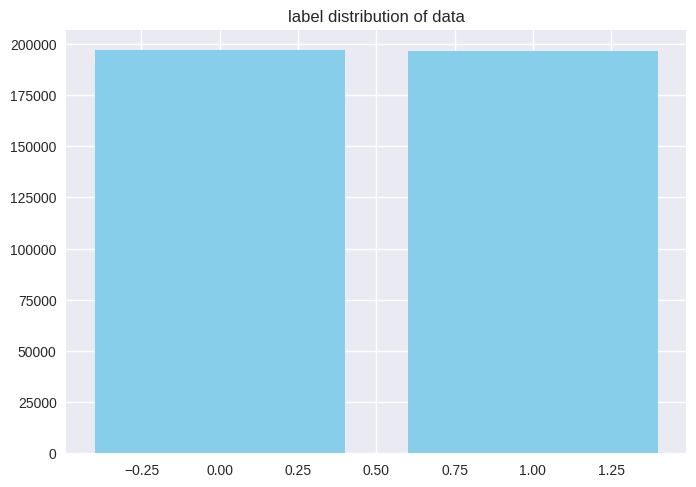

In [34]:
## 클래스 라벨 비율 분포 확인
import matplotlib.pyplot as plt
plt.style.use('seaborn')

plt.bar(train_data['label'].value_counts().index, train_data['label'].value_counts(), color = 'skyblue')
plt.title('label distribution of data')

Text(0.5, 1.0, 'document length distribution')

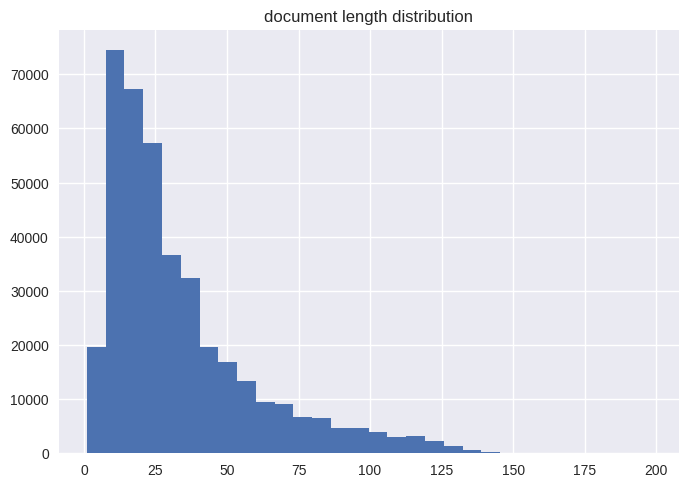

In [35]:
document_length = [len(x) for x in train_data['preprocessed_sentence'].astype(str)]
plt.hist(document_length, bins = 30)
plt.title('document length distribution')

In [36]:
numpy_document_length = np.array(document_length)
print('전체 문서의 (평균, 표준편차) : ({}, {}):'.format(numpy_document_length.mean(), numpy_document_length.std()))
print('전체 문서의 (최소, 최대) : ({}, {})'.format(numpy_document_length.min(), numpy_document_length.max()))
print('전체 문서의 개수 : {}'.format(len(document_length)))
print('문서의 길이가 3보다 큰 것의 개수 : {}'.format(len(numpy_document_length[numpy_document_length > 3])))

전체 문서의 (평균, 표준편차) : (33.27132700819693, 26.285138750969825):
전체 문서의 (최소, 최대) : (1, 198)
전체 문서의 개수 : 393562
문서의 길이가 3보다 큰 것의 개수 : 390359


<h1> 4. 텍스트 데이터 to 벡터화</h1>
전체 데이터 가지고 validation set으로 나눠도 됌.



In [ ]:
from sklearn.model_selection import train_test_split

# validation_set 고정하는 경우
train_X, test_X, y_train, y_test = train_test_split(train_data['preprocessed_sentence'], train_data['label'],
                                                    test_size = 0.25, random_state = 2023, stratify = train_data['label'])

train_X.shape, test_X.shape, y_train.shape, y_test.shape

((295171,), (98391,), (295171,), (98391,))

In [ ]:
X_train = []
X_test = []

for sentence in tqdm(train_X):
    tokenized_sentence = str(sentence).split(' ')
    X_train.append(tokenized_sentence)

for sentence in tqdm(test_X):
    tokenized_sentence = str(sentence).split(' ')
    X_test.append(tokenized_sentence)

100%|██████████| 98391/98391 [00:00<00:00, 448716.87it/s]


In [37]:
# validation_set을 나중에 나누는 경우
X = train_data['preprocessed_sentence']
y = train_data['label']

X_train = []
for sentence in tqdm(X):
    tokenized_sentence = str(sentence).split(' ')
    X_train.append(tokenized_sentence)

100%|██████████| 393562/393562 [00:01<00:00, 245690.33it/s]


In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index['그냥'])

34


In [39]:
threshold = 10
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 80892
등장 빈도가 9번 이하인 희귀 단어의 수: 63347
단어 집합에서 희귀 단어의 비율: 78.31058695544677
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.908264568757788


In [40]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 17546


In [41]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
#X_test = tokenizer.texts_to_sequences(X_test) 위에서 train_test_split으로 고정한 경우에는 주석 해제

In [42]:
print(X_train[:3])

[[126, 181, 572, 239, 17, 143, 856], [10, 14381, 799, 20, 405, 15, 1, 52, 9, 32, 6], [90, 178, 438, 2]]


In [43]:
y_train = np.array(y)
#y_train = np.array(y_train)
#y_test = np.array(y_test)

<h3> 빈 샘플 제거하기 </h3>

In [44]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis = 0)
y_train = np.delete(y_train, drop_train, axis = 0)
print(len(X_train))
print(len(y_train))

392861
392861


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 12.318748870465635


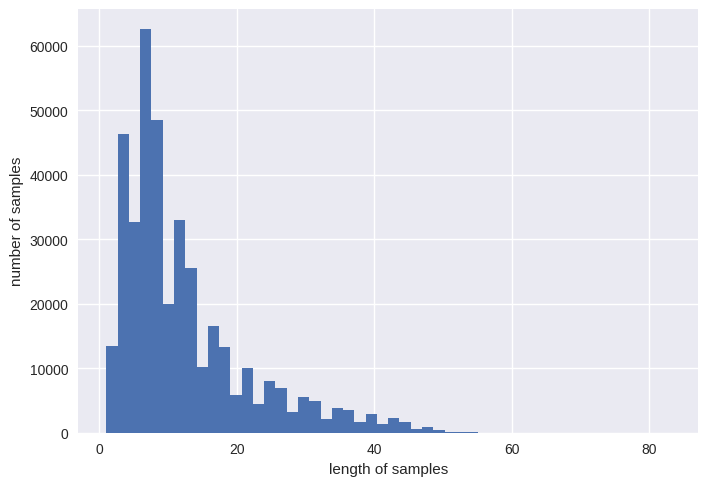

In [46]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [47]:
max_len = 83
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 83 이하인 샘플의 비율: 100.0


In [48]:
X_train = pad_sequences(X_train, maxlen=max_len)
#X_test = pad_sequences(X_test, maxlen=max_len)

<h1> 5. 모델 돌리기(LSTM) </h1>

In [49]:
y_train = np.array(y_train).astype(np.int8)
#y_test = np.array(y_test).astype(np.int8)

In [50]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
#model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
#history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_data=[X_test, y_test])
history = model.fit(X_train, y_train, epochs = 30, batch_size = 128, validation_split = 0.2)

Epoch 1/30
2456/2456 [==============================] - 77s 30ms/step - loss: 0.3293 - acc: 0.8610 - val_loss: 0.2930 - val_acc: 0.8805
Epoch 2/30
2456/2456 [==============================] - 25s 10ms/step - loss: 0.2601 - acc: 0.8948 - val_loss: 0.2813 - val_acc: 0.8860
Epoch 3/30
2456/2456 [==============================] - 22s 9ms/step - loss: 0.2256 - acc: 0.9102 - val_loss: 0.2858 - val_acc: 0.8858
Epoch 4/30
2456/2456 [==============================] - 23s 9ms/step - loss: 0.1930 - acc: 0.9252 - val_loss: 0.3046 - val_acc: 0.8833
Epoch 5/30
2456/2456 [==============================] - 20s 8ms/step - loss: 0.1625 - acc: 0.9380 - val_loss: 0.3525 - val_acc: 0.8779
Epoch 6/30
2456/2456 [==============================] - 20s 8ms/step - loss: 0.1372 - acc: 0.9485 - val_loss: 0.4085 - val_acc: 0.8768
Epoch 7/30
2456/2456 [==============================] - 20s 8ms/step - loss: 0.1155 - acc: 0.9564 - val_loss: 0.4608 - val_acc: 0.8728
Epoch 8/30
2456/2456 [==============================]

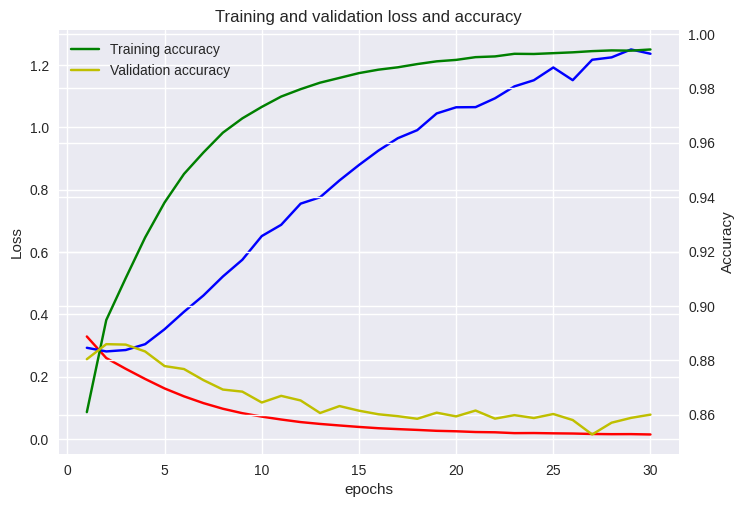

In [51]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
# 그래프 생성
fig, ax1 = plt.subplots()

ax1.plot(epochs, loss, 'r', label = 'Training loss')
ax1.plot(epochs, val_loss, 'b', label = 'Validation loss')

ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
ax2.plot(epochs, accuracy, 'g', label = 'Training accuracy')
ax2.plot(epochs, val_accuracy, 'y', label = 'Validation accuracy')

ax2.set_xlabel('epochs')
ax2.set_ylabel('Accuracy')

plt.title('Training and validation loss and accuracy')
plt.legend()
plt.show()

In [52]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
#history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_data=[X_test, y_test])
history = model.fit(X_train, y_train, epochs = 30, batch_size = 128, validation_split = 0.2)

Epoch 1/30
2456/2456 [==============================] - 57s 22ms/step - loss: 0.3236 - acc: 0.8629 - val_loss: 0.2862 - val_acc: 0.8821
Epoch 2/30
2456/2456 [==============================] - 22s 9ms/step - loss: 0.2549 - acc: 0.8970 - val_loss: 0.2835 - val_acc: 0.8854
Epoch 3/30
2456/2456 [==============================] - 20s 8ms/step - loss: 0.2192 - acc: 0.9133 - val_loss: 0.2967 - val_acc: 0.8817
Epoch 4/30
2456/2456 [==============================] - 20s 8ms/step - loss: 0.1868 - acc: 0.9276 - val_loss: 0.3234 - val_acc: 0.8803
Epoch 5/30
2456/2456 [==============================] - 19s 8ms/step - loss: 0.1567 - acc: 0.9399 - val_loss: 0.3618 - val_acc: 0.8773
Epoch 6/30
2456/2456 [==============================] - 18s 7ms/step - loss: 0.1309 - acc: 0.9500 - val_loss: 0.4430 - val_acc: 0.8734
Epoch 7/30
2456/2456 [==============================] - 18s 7ms/step - loss: 0.1101 - acc: 0.9580 - val_loss: 0.4974 - val_acc: 0.8718
Epoch 8/30
2456/2456 [==============================] 

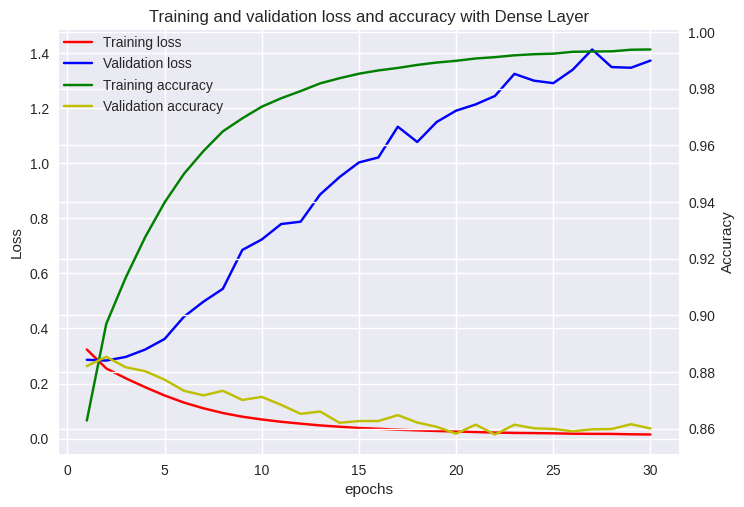

In [62]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
# 그래프 생성
fig, ax1 = plt.subplots()

ax1.plot(epochs, loss, 'r', label = 'Training loss')
ax1.plot(epochs, val_loss, 'b', label = 'Validation loss')

ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc = (0, 0.89))
ax2 = ax1.twinx()
ax2.plot(epochs, accuracy, 'g', label = 'Training accuracy')
ax2.plot(epochs, val_accuracy, 'y', label = 'Validation accuracy')

ax2.set_xlabel('epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc = (0, 0.79))
plt.title('Training and validation loss and accuracy with Dense Layer')
plt.show()